In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Load cifar Dataset

In [ ]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


##ResNet
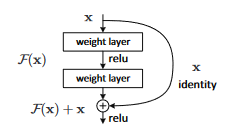


One of the drawbacks of VGG was that it couldn't go as deep as wanted because it started to lose the generalization capability (i.e, it started overfitting). This is because as a neural network gets deeper, the gradients from the loss function start to shrink to zero and thus the weights are not updated. This problem is known as the vanishing gradient problem. ResNet essentially solved this problem by using skip connections.

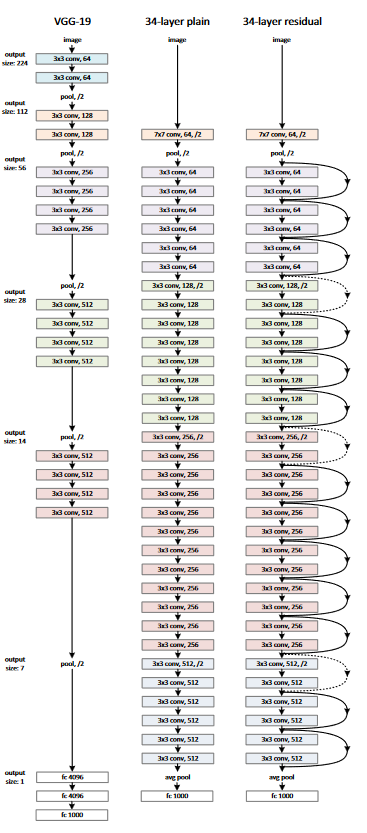!

In the figure above, we can see that, in addition to the normal connections, there is a direct connection that skips some layers in the model (skip connection).  With the skip connection, the output changes from h(x) = f(wx +b) to h(x) = f(x) + x. These skip connections help as they allow an alternate shortcut path for the gradients to flow through. Below is the architecture of the 34-layer ResNet.




Residual Block
Before starting with the network, we need to build a ResidualBlock that we can re-use through out the network. The block (as shown in the architecture) contains a skip connection that is an optional parameter ( downsample ). Note that in the forward , this is applied directly to the input, x, and not to the output, out.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

## Downsampling
The down sampling of the volume though the network is achieved by increasing the stride instead of a pooling operation like normally CNNs do. In fact, only one max pooling operation is performed in our Conv1 layer, and one average pooling layer at the end of the ResNet, right before the fully connected dense layer in Figure 1.

We can also see another repeating pattern over the layers of the ResNet, the dot layer representing the change of the dimensionality. This agrees with what we just said. The first operation of each layer is reducing the dimension, so we also need to resize the volume that goes through the skip connection, so we could add them like we did in Figure 7.

This difference on the skip connections are the so called in the paper as Identity Shortcut and Projection Shortcut. The identity shortcut is the one we have already discussed, simply bypassing the input volume to the addition operator. The projection shortcut performs a convolution operation to ensure the volumes at this addition operation are the same size. From the paper we can see that there are 2 options for matching the output size. Either padding the input volume or perform 1x1 convolutions. Here, this second option is shown.




ResNet


Note that there are three blocks in the architecture, containing 3, 3, 6, and 3 layers respectively. To make this block, we create a helper function _make_layer. The function adds the layers one by one along with the Residual Block. After the blocks, we add the average pooling and the final linear layer.



In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [ ]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Loss: 0.9993
Accuracy of the network on the 5000 validation images: 73.5 %
Epoch [2/20], Loss: 0.2562
Accuracy of the network on the 5000 validation images: 78.24 %
Epoch [3/20], Loss: 1.3213
Accuracy of the network on the 5000 validation images: 79.32 %
Epoch [4/20], Loss: 0.5242
Accuracy of the network on the 5000 validation images: 80.16 %
Epoch [5/20], Loss: 0.3557
Accuracy of the network on the 5000 validation images: 81.74 %
Epoch [6/20], Loss: 0.1024
Accuracy of the network on the 5000 validation images: 82.14 %
Epoch [7/20], Loss: 0.5635
Accuracy of the network on the 5000 validation images: 83.1 %
Epoch [8/20], Loss: 0.2121
Accuracy of the network on the 5000 validation images: 82.76 %
Epoch [9/20], Loss: 1.3202
Accuracy of the network on the 5000 validation images: 82.7 %
Epoch [10/20], Loss: 0.3079
Accuracy of the network on the 5000 validation images: 83.34 %
Epoch [11/20], Loss: 0.2003
Accuracy of the network on the 5000 validation images: 82.78 %
Epoch [12/2

In [8]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 82.71 %


#References
https://www.youtube.com/watch?v=d2kxUVwWWwU

https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0

https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/